In [1]:
import os
os.chdir('../360VOT')

from lib.omni import *
from lib.utils import *
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from typing import Tuple, List
import numpy as np
import cv2

In [2]:
def get_frame_and_bfov(seq_num, frame_num):
    # predictions file
    file_path = f'/Users/aarsh/Desktop/CGVI/Thesis/benchmark/360VOT-bfov-results/AiATrack-360-bfov/{seq_num}.txt'
    frame = cv2.imread(f'/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/{seq_num}/image/{frame_num}.jpg')
    # Read the text file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize a dictionary to hold the frame data
    frames_dict = {}

    # Parse each line in the text file
    for frame_number, line in enumerate(lines, start=0):
        values = line.split()
        clon, clat, fov_h, fov_v, rotation = map(float, values)
        
        # Organize the data frame number-wise
        frame_data = {
            "clon": clon,
            "clat": clat,
            "fov_h": fov_h,
            "fov_v": fov_v,
            "rotation": rotation
        }
        
        frames_dict[frame_number] = frame_data
    
    return frames_dict, frame

def get_frame_and_bbox(seq_num, frame_num):
    # predictions file
    file_path = f'/Users/aarsh/Desktop/CGVI/Thesis/benchmark/360VOT-bbox-results/AiATrack-360/{seq_num}.txt'
    frame = cv2.imread(f'/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/{seq_num}/image/{frame_num}.jpg')
    # Read the text file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize a dictionary to hold the frame data
    frames_dict = {}

    # Parse each line in the text file
    for frame_number, line in enumerate(lines, start=0):
        values = line.split()
        x, y, w, h= map(float, values)
        
        # Organize the data frame number-wise
        frame_data = {
            "x": x,
            "y": y,
            "w": w,
            "h": h,
        }
        
        frames_dict[frame_number] = frame_data
    
    return frames_dict, frame

## Initialize `OmniImage`

In [3]:
omni = OmniImage(img_w=3840,img_h=1920)

## Get BFoV information first, cause this is where the process starts

In [4]:
seq_num = 606
frames_dict, cur_frame = get_frame_and_bfov('0018', '000606')
global_bfov_cur = Bfov(frames_dict[seq_num]['clon'], frames_dict[seq_num]['clat'], frames_dict[seq_num]['fov_h'], frames_dict[seq_num]['fov_v'])

# Plot the BfoV for this frame

2


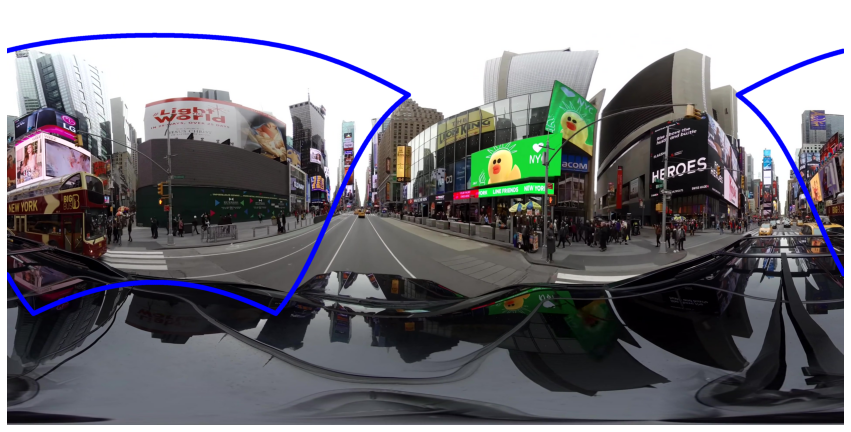

In [5]:
curr_frame_copy = cur_frame.copy()
plt.figure(figsize=(15, 15))
plt.imshow(omni.plot_bfov(cur_frame_copy, global_bfov_cur, size = 20)[:, :, ::-1])
plt.axis('off')
plt.show()

## Get `local_search_region_next` in the spherical coordinate system, and get `ref_u`, `ref_v` for later usage (coming to this soon).

- This computation inherently handles the `projection` type logic based on `fov_h` and `fov_v` params of the `global_bfov_cur`

In [6]:
local_search_region_next, ref_u, ref_v = omni.crop_bfov(cur_frame, global_bfov_cur)

2


## View next frame local search region

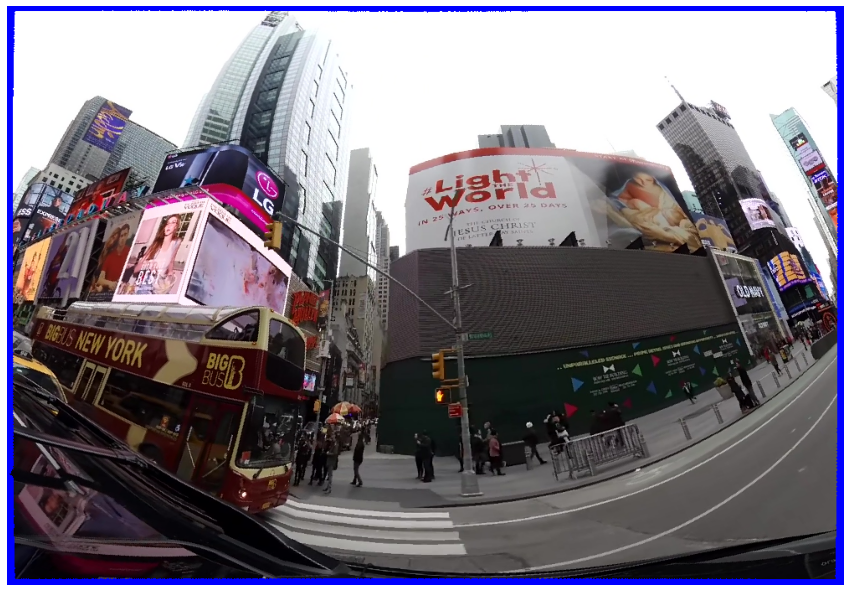

In [7]:
plt.figure(figsize=(15, 15))
plt.imshow(local_search_region_next[:, :, ::-1])
plt.axis('off')
plt.show()

## Tracker makes predictions on `local_search_region_cur` and outputs a `local_bbox`

1. this `local_bbox` is then converted to a `global_bfov_next` with `omni.localBbox2Bfov(local_bbox, ref_u, ref_v)`, but since we only have `global` values i'll use `bbox2bfov` instead.

In [8]:
new_seq_num = 607
frames_dict_bbox, next_frame = get_frame_and_bbox('0018', '000607') # one step ahead because search region is based around the previous prediction
bbox = [int(frames_dict_bbox[new_seq_num]['x']), int(frames_dict_bbox[new_seq_num]['y']), int(frames_dict_bbox[new_seq_num]['w']), int(frames_dict_bbox[new_seq_num]['h'])]
global_bbox = x1y1wh2bbox(bbox)

## Plot this `global_bbox`

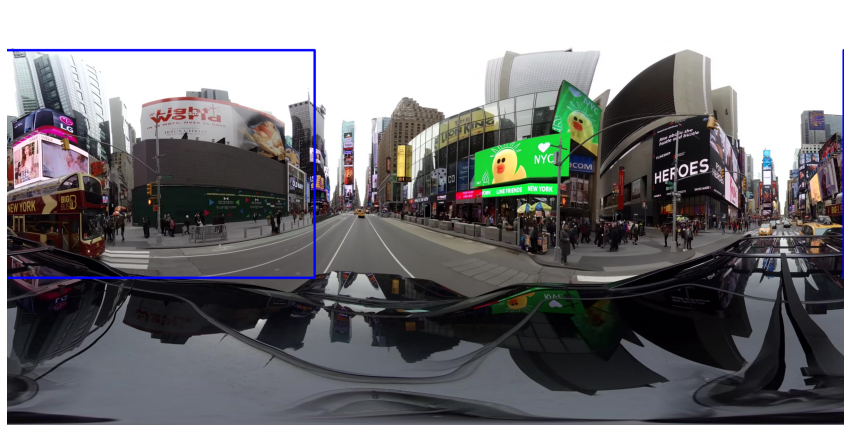

In [9]:
next_frame_copy = next_frame.copy()
plt.figure(figsize=(15, 15))
plt.imshow(omni.plot_bbox(next_frame_copy, global_bbox)[:, :, ::-1])
plt.axis('off')
plt.show()

## Convert this `global_bbox` to a `global_bfov` to get `local_search_region_next_frame`

In [10]:
global_bfov_next, _, _, _, _ = omni.bbox2Bfov(global_bbox)

## Get `local_search_region_next_frame` in the spherical coordinate system, and update `ref_u` and `ref_v` to be `new_ref_u`, and `new_ref_v` for the next round

- This computation inherently handles the `projection` type logic based on `fov_h` and `fov_v` params of the `global_Bfov_next`

In [11]:
local_search_region_next_frame, new_ref_u, new_ref_v = omni.crop_bfov(next_frame, global_bfov_next)

2


## View next local search region

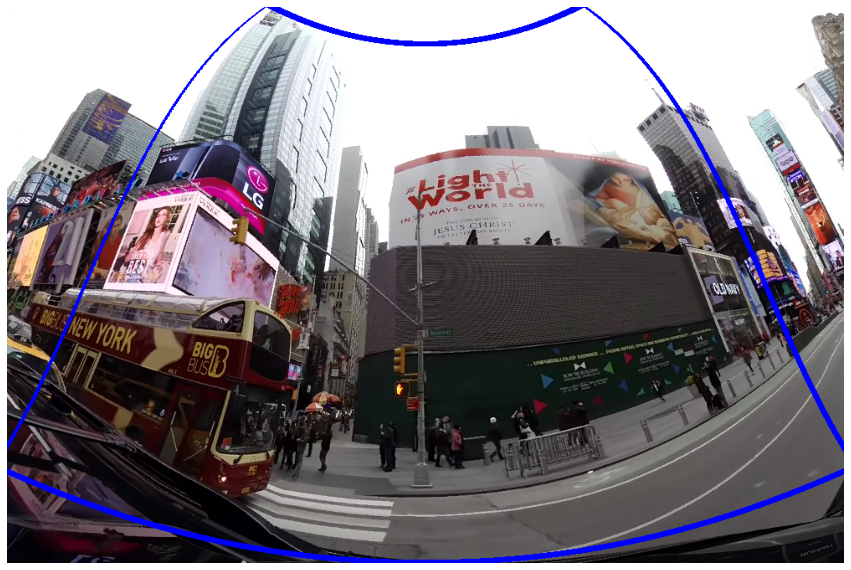

In [12]:
plt.figure(figsize=(15, 15))
plt.imshow(local_search_region_next_frame[:, :, ::-1])
plt.axis('off')
plt.show()

In [13]:
# import pandas as pd

# df = pd.read_excel('/Users/aarsh/Desktop/CGVI/Thesis/Data/360VOT_attribute.xlsx', engine='openpyxl')
# df.head()

In [14]:
# crossing_border_df = df[df['CB(cross border)'] == 1.0]
# crossing_border_df.tail()

In [15]:
import cv2
import os
from multiprocessing import Pool
from tqdm import tqdm

def read_image(image_path):
    return cv2.imread(image_path)

def create_video_from_images(image_folder, output_video_path, fps):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")]
    images.sort()
    
    # Get dimensions of the images
    frame = cv2.cvtColor(cv2.imread(os.path.join(image_folder, images[0])), cv2.COLOR_BGR2RGB)
    height, width, layers = frame.shape
    
    video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    image_paths = [os.path.join(image_folder, img) for img in images]
    
    # Use multiprocessing to read images in parallel
    with Pool() as pool:
        for image in tqdm(pool.imap(read_image, image_paths), total=len(images)):
            video.write(image)
    
    video.release()

image_folder = '/Users/aarsh/Desktop/0117_uav_tangent_50_90'
output_video_path = '/Users/aarsh/Desktop/0117_uav_tangent_50_90.mp4'
fps = 24  # Frames per second

create_video_from_images(image_folder, output_video_path, fps)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/aarsh/Desktop/0117_uav_tangent_50_90'